# Classifying languages
## Part 1

We used the following two commands to get the list of anomaly scores:

`java -jar negsel2.jar -self english.train -n 10 -r 4 -c -l < english.test > ./ClassifyingLanguagesFiles/englishtest.txt`

`java -jar negsel2.jar -self english.train -n 10 -r 4 -c -l < tagalog.test > ./ClassifyingLanguagesFiles/tagalogtest.txt`


The remainder of the AUC calculations will be done in this Notebook using these text files.


In [6]:
# It is also required to install scikit-learn. Uncomment the following lines
# import sys
# !{sys.executable} -m pip install scikit-learn

In [7]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [18]:
english = np.loadtxt("ClassifyingLanguagesFiles/englishtest.txt", dtype=float)
tagalog = np.loadtxt("ClassifyingLanguagesFiles/tagalogtest.txt", dtype=float)

def compute_roc_auc(file1, file2):
    maximum = max(max(file1), max(file2))

    #changing the anomaly scores to be between 0 and 1, 
    #this doesn't matter for the ROC curve since it is based on true positive / false positive etc.
    file1 = [[x/maximum,0] for x in file1]
    file2 = [[x/maximum,1] for x in file2]

    #merging the two test string sets
    anomaly_scores = file1 + file2

    #sort by anomaly score
    anomaly_scores.sort(reverse=True)

    #split the list up into actual class (y) and anomal score (y_pred)
    y = [y for [x,y] in anomaly_scores]
    y_pred = [x for [x,y] in anomaly_scores]

    #using the functions from sklearn to easily calculate the roc_curve
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, threshold, roc_auc

fpr, tpr, threshold, roc_auc = compute_roc_auc(english, tagalog)

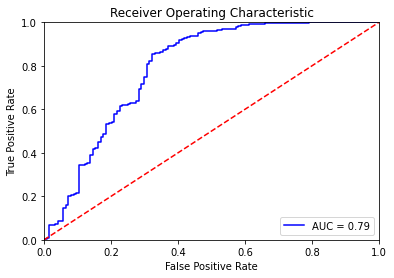

In [19]:
def plot_ROC(fpr, tpr, roc_auc, title = ''):
    #plotting the RCO
    plt.title('Receiver Operating Characteristic'+title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_ROC(fpr, tpr, roc_auc)

## Part 2

We used the bash commands to get the list of anomaly scores for $1 \leq r \leq 9$:

<code>for idx in {1..9}
 do
     time (java -jar negsel2.jar -self english.train -n 10 -r $idx -c -l < english.test > ./ClassifyingLanguagesFiles/englishtest_r${idx}.txt ;
     java -jar negsel2.jar -self english.train -n 10 -r $idx -c -l < tagalog.test > ./ClassifyingLanguagesFiles/tagalogtest_r${idx}.txt)
 done
</code>

Recall that `r` indicates that we will build a repertoire containing all patterns of length `n` = 10 that do not share any contiguous substring of length more than `r` with the train data. If we set `r` to 1, then the repetoire is relatively small. Moreover, the strings that do occur there are mostly weird combinations of consonants: many two-letter strings consisting of a vowel and a consonant (or two vowels) occur naturally in the English language and in the train set and are excluded. This also causes almost all Tagalog strings to be excluded, so almost all Tagalog strings are categorized as English.

On the other hand, if we set `r` to 9, then the only strings are excluded are the strings that have a  contiguous substring length more than 9 (i.e. with length 10) in common with the training data, so the repetoire is just the set of strings that do not occur exactly in the training data. This means that every string which is not in the training data is classified as Tagalog. So although all Tagalog strings are classified as Tagalog, also almost all English strings are classified as Tagalog.

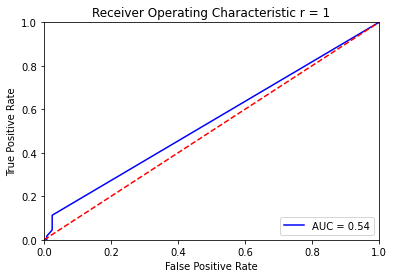

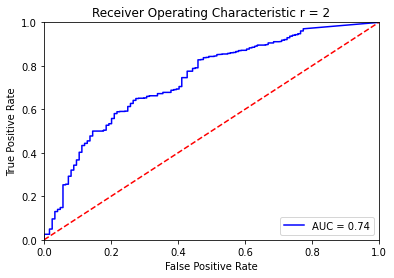

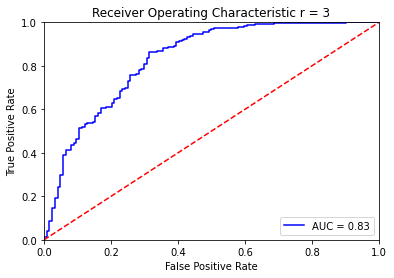

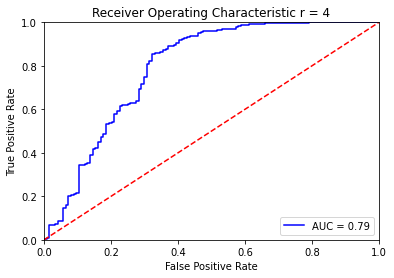

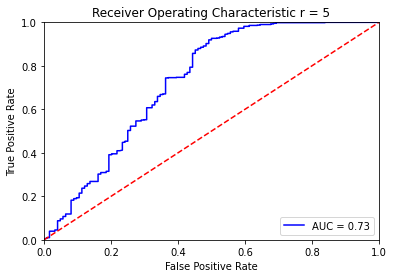

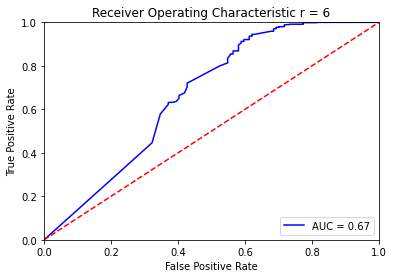

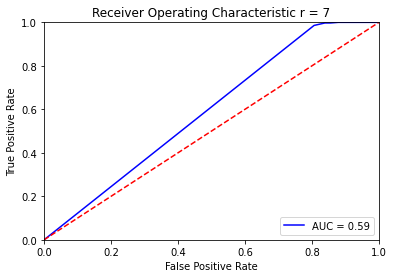

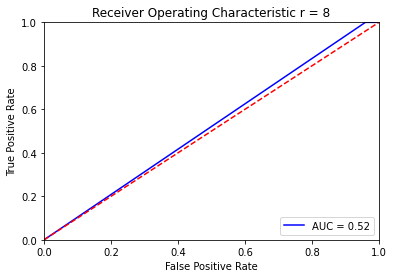

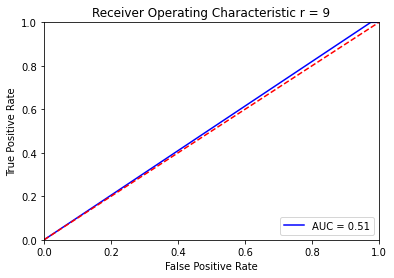

In [17]:
for idx in range(1, 10):
    english_r = np.loadtxt("ClassifyingLanguagesFiles/englishtest_r"+str(idx)+".txt", dtype=float)
    tagalog_r = np.loadtxt("ClassifyingLanguagesFiles/tagalogtest_r"+str(idx)+".txt", dtype=float)

    fpr, tpr, threshold, roc_auc = compute_roc_auc(english_r, tagalog_r) 
    plot_ROC(fpr, tpr, roc_auc, ' r = '+str(idx))

As $r$ increases, the time it takes to execute the code increases substantially: for $r=1$ it took 0.55 seconds, for $r=9$ it took 17.18 seconds, with the time gradually increasing in $r$. This is as expected, because the size of the repetoire increases as $r$ increases. 

As expected, both $r=1$ and $r=9$ are bad at correctly identifying the anomalies. When choosing between $r=1$ and $r=9$, it seems that $r=1$ is better, simply because the AUC is slightly higher. But both settings perform quite badly, so it would be better to choose a value for $r$ like 3 or 4.

The highest AUC score is found for $r=3$, namely 0.83. However, the AUC score is not the only measure of how well a value of $r$ performs. Depending on the context, different parts of the ROC-curve are important, whereas the AUC score takes into account the whole curve. For example, we may want to maximize the True Positive Rate while ensuring that the False Positive Rate is at most 0.2. In this case we get the best results again for $r=3$. In fact, for this case it seems that the $r=3$ curve lies (almost) entirely above the other ROC curves, so here $r=3$ is clearly the best value of $r$.

## Part 3

It is not given which value of $r$ to use, but looking at the results above, we want to use $r=3$ or $r=4$ again because that really showed a difference between English and Tagalog.
We executed the following commands:

<code>for idx in {3, 4}
 do
     java -jar negsel2.jar -self english.train -n 10 -r $idx -c -l < ./lang/plautdietsch.txt > ./ClassifyingLanguagesFiles/plautdietschtest${idx}.txt
     java -jar negsel2.jar -self english.train -n 10 -r $idx -c -l < ./lang/hiligaynon.txt > ./ClassifyingLanguagesFiles/hiligaynontest${idx}.txt
     java -jar negsel2.jar -self english.train -n 10 -r $idx -c -l < ./lang/middle-english.txt > ./ClassifyingLanguagesFiles/middleenglishtest${idx}.txt
     java -jar negsel2.jar -self english.train -n 10 -r $idx -c -l < ./lang/xhosa.txt > ./ClassifyingLanguagesFiles/xhosatest${idx}.txt
 done
</code>

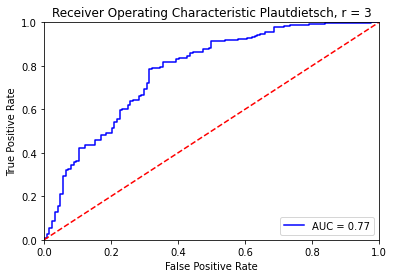

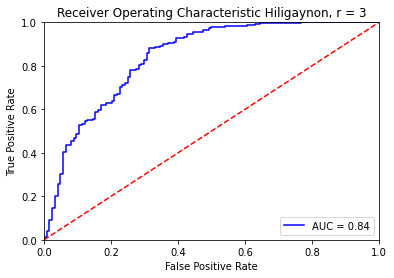

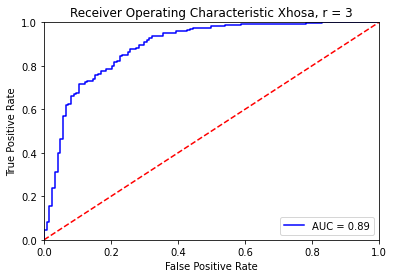

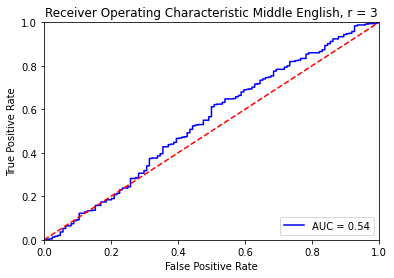

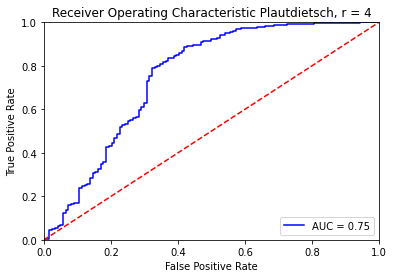

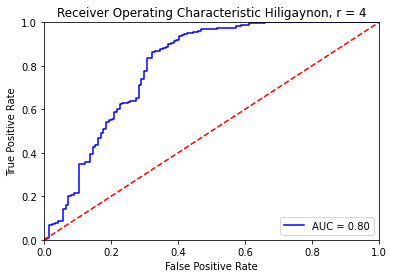

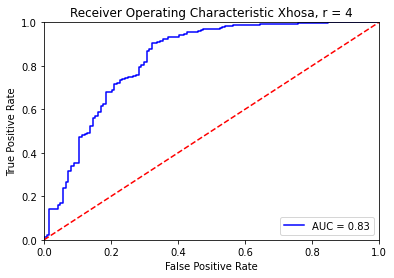

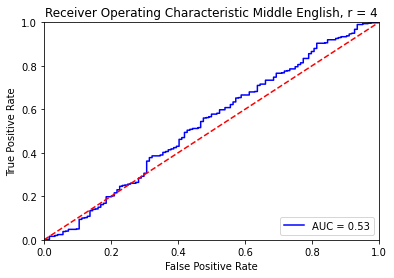

In [23]:
for idx in [3, 4]:
    english = np.loadtxt("ClassifyingLanguagesFiles/englishtest_r"+str(idx)+".txt", dtype=float)
    plautdietsch = np.loadtxt("ClassifyingLanguagesFiles/plautdietschtest"+str(idx)+".txt", dtype=float)
    hiligaynon = np.loadtxt("ClassifyingLanguagesFiles/hiligaynontest"+str(idx)+".txt", dtype=float)
    xhosa = np.loadtxt("ClassifyingLanguagesFiles/xhosatest"+str(idx)+".txt", dtype=float)
    middle_english = np.loadtxt("ClassifyingLanguagesFiles/middleenglishtest"+str(idx)+".txt", dtype=float)

    fpr, tpr, threshold, roc_auc = compute_roc_auc(english, plautdietsch) 
    plot_ROC(fpr, tpr, roc_auc, ' Plautdietsch, r = '+str(idx))

    fpr, tpr, threshold, roc_auc = compute_roc_auc(english, hiligaynon) 
    plot_ROC(fpr, tpr, roc_auc, ' Hiligaynon, r = '+str(idx))

    fpr, tpr, threshold, roc_auc = compute_roc_auc(english, xhosa) 
    plot_ROC(fpr, tpr, roc_auc, ' Xhosa, r = '+str(idx))

    fpr, tpr, threshold, roc_auc = compute_roc_auc(english, middle_english) 
    plot_ROC(fpr, tpr, roc_auc, ' Middle English, r = '+str(idx))

## Observations

1. Middle English is the most difficult to distinguish from English, Xhosa the easiest.
2. Middle English has a much lower AUC than the others. This can be explained by the fact that Middle English is much more similar to English than the other languages and therefore it is much there are more false positives compared to true positives.
3. Plautdietsch has its origins in Dutch and German, and it is a West Germanic language like English. Hiligaynon is spoken in the Philippines. Xhosa is spoken in Sotuh-Africa. We would say that Dutch/German is more similar to English than the other two languages, this can also be found in the ROC because the AUC from Plautdietsch is lower than for Xhosa and Hiligaynon. 
4. Both Xhosa and Hiligaynon are very different from English, but we do not know why Xhosa performs (slightly) better. 
5. For all four languages it seems that $r=3$ performs better than $r=4$. 